<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_3g_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adding some longer residual connections to try to preserve some small details which seem to be getting lost; added batch norm; replaced 6x5 convolution with global average pool followed by 1x1 convolution.

Erased some of the training output for version 3.1 to keep size of notebook manageable.

**3.1g** - Now that the autoencoder seems to be close to overfitting the training data, I'm going to try to add an adversarial network to it to see how that works.

Updated training function so that it uses inputs and reconstructions from different batches rather than using the reconstructed and real versions of the same images for each batch. A side effect of this is that the discriminator is trained at most once every other iteration.

20190701 - Added code to only train discriminator when it's accuracy is below a certain threshold. It was getting tiring trying to tune the training so that one wouldn't overload the other one. We'll see how this works.

20190819 - Retraining from scratch as GAN. There were many errors in the code I was previously trying to use AND the discriminator didn't seem to be doing a very good job of doing any useful discrimination, so I decided to start over from scratch with the bugs in the code fixed.

In [0]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline
import zipfile
import os

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [0]:
# !gsutil cp gs://{bucket_name}/model_30_trained.pt ./model_3g_e.pt
!gsutil cp gs://{bucket_name}/gen_model_30.pt ./gen_model_3.pt
!gsutil cp gs://{bucket_name}/disc_model_30.pt ./disc_model_3.pt

Copying gs://pneumonia/gen_model_30.pt...
\ [1 files][294.9 MiB/294.9 MiB]   48.9 MiB/s                                   
Operation completed over 1 objects/294.9 MiB.                                    
Copying gs://pneumonia/disc_model_30.pt...
| [1 files][ 44.6 MiB/ 44.6 MiB]                                                
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
# if not os.path.exists("celeba-dataset.zip"):
# #   !kaggle datasets download -d jessicali9530/celeba-dataset
#   !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
#   zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
#   zip_ref.extractall('data')
#   zip_ref.close()

#   zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()
  
# if not os.path.exists("Training_Pictures.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
#   zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()  

# if not os.path.exists("imdb_images3.zip"):
#   !gsutil cp gs://{bucket_name}/imdb_images3.zip ./imdb_images3.zip
#   zip_ref = zipfile.ZipFile('imdb_images3.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()

# if not os.path.exists("GWB_200x200_JPEG.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
#   zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
#   zip_ref.extractall('data/images')               
#   zip_ref.close()  

In [0]:
if not os.path.exists("celeb_a_good.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeb_a_good.zip ./celeb_a_good.zip
  zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
  zip_ref.extractall('data/images/celeb_a')
  zip_ref.close()

if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images/training')
  zip_ref.close()
  
# if not os.path.exists("imdb_crop_good.zip"):  
#   !gsutil cp gs://{bucket_name}/imdb_crop_good.zip ./imdb_crop_good.zip
#   zip_ref = zipfile.ZipFile('imdb_crop_good.zip', 'r')
#   zip_ref.extractall('data/images/imdb')
#   zip_ref.close()

# if not os.path.exists("crop_part1_good.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_good.zip ./crop_part1_good.zip
#   zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
#   zip_ref.extractall('data/images/crop_parta')
#   zip_ref.close()   

Copying gs://pneumonia/celeb_a_good.zip...
- [1 files][  1.1 GiB/  1.1 GiB]   66.1 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      
--2019-08-19 09:02:44--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.155.13
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.155.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 955202 (933K) [application/zip]
Saving to: ‘Training_Pictures.zip’

Training_Pictures.z 100%[===================>] 932.81K   613KB/s    in 1.5s    

2019-08-19 09:02:47 (613 KB/s) - ‘Training_Pictures.zip’ saved [955202/955202]



In [0]:
# get test data
if not os.path.exists("wiki_images_good.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./wiki_images_good.zip
  zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()  

if not os.path.exists("faces94.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
  zip_ref = zipfile.ZipFile('faces94.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()
  
if not os.path.exists("faces96.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
  zip_ref = zipfile.ZipFile('faces96.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()

if not os.path.exists("faces95.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
  zip_ref = zipfile.ZipFile('faces95.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()

if not os.path.exists("GWB_200x200_JPEG.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
  zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()  
  
if not os.path.exists("celeb_a_test.zip"):
  !gsutil cp gs://{bucket_name}/celeb_a_test.zip ./celeb_a_test.zip
  zip_ref = zipfile.ZipFile('celeb_a_test.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()       
  
if not os.path.exists("wiki_crop_test.zip"):
  !gsutil cp gs://{bucket_name}/wiki_crop_test.zip ./wiki_crop_test.zip
  zip_ref = zipfile.ZipFile('wiki_crop_test.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()     
  
if not os.path.exists("imdb_crop_test.zip"):
  !gsutil cp gs://{bucket_name}/imdb_crop_test.zip ./imdb_crop_test.zip
  zip_ref = zipfile.ZipFile('imdb_crop_test.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()
  
if not os.path.exists("crop_part1_test.zip"):
  !gsutil cp gs://{bucket_name}/crop_part1_test.zip ./crop_part1_test.zip
  zip_ref = zipfile.ZipFile('crop_part1_test.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()     

Copying gs://pneumonia/wiki_images_good.zip...
\ [1 files][ 94.7 MiB/ 94.7 MiB]                                                
Operation completed over 1 objects/94.7 MiB.                                     
--2019-08-19 09:02:55--  https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18845407 (18M) [application/zip]
Saving to: ‘faces94.zip’

faces94.zip         100%[===================>]  17.97M  5.48MB/s    in 3.3s    

2019-08-19 09:03:00 (5.48 MB/s) - ‘faces94.zip’ saved [18845407/18845407]

--2019-08-19 09:03:02--  https://cswww.essex.ac.uk/mv/allfaces/faces96.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21040168 (2

In [0]:
# get test data
# if not os.path.exists("faces94.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
#   zip_ref = zipfile.ZipFile('faces94.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
# if not os.path.exists("wiki_images2.zip"):
#   !gsutil cp gs://{bucket_name}/wiki_images2.zip ./wiki_images.zip
#   zip_ref = zipfile.ZipFile('wiki_images.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()

# if not os.path.exists("faces96.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
#   zip_ref = zipfile.ZipFile('faces96.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
  
# if not os.path.exists("faces95.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
#   zip_ref = zipfile.ZipFile('faces95.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()

# if not os.path.exists("crop_part1.tar.gz"):
#   !gsutil cp gs://{bucket_name}/crop_part1.tar.gz ./crop_part1.tar.gz
#   !tar -xf crop_part1.tar.gz -C data/images

In [0]:
BATCH_SIZE = 18
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=5, translate=(0.075,0.075), scale=(0.9,1.15), shear=4, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.RandomResizedCrop((192,160), scale=(0.8, 1.20)),
      torchvision.transforms.ToTensor(),
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop((192,160), scale=(0.95, 1.05)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

In [0]:
for (images, _) in train_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [0]:
for (images, _) in test_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [0]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 166927
    Root location: data/images

In [0]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 62516
    Root location: data/test_images

In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

64.0

### Create Models

In [0]:
epoch_list = []

In [0]:
def vae_loss(x, x_hat, d_faked=None, debug=False):
    beta_mse = 10.0
    beta_kld = 0.1
    beta_gloss = 1.0
    
    # MSE for reconstructions
    MSE = nn.functional.mse_loss(x, x_hat)
    MSE *= beta_mse
    
    # weight the MSE loss higher so the discriminator loss doesn't overwhelm it
    if d_faked is not None:
        ones = torch.ones(d_faked.shape[0]).cuda()
        g_loss =  nn.functional.binary_cross_entropy_with_logits(d_faked, ones, reduction="mean")
        g_loss *= beta_gloss
    else:
        g_loss = torch.zeros(1).cuda()
        
    # print out loss info if we want to debug
    if debug:
        print("MSE Loss Raw:", MSE)
        print("MSE Loss Weighted:", MSE * beta_mse)
        print("KLD Loss Raw:", KLD)
        print("KLD Loss Weighted:", KLD * beta_kld)
        if d_faked is not None:
            print("Disc Loss Raw:", g_loss)
            print("Disc Loss Weighted:", g_loss * beta_gloss)
        print("Total Loss (weighted):", total_loss)
    
    return MSE + g_loss, MSE, 0, g_loss
  
def disc_loss(d_true, d_faked):
    ones = torch.ones(d_true.shape[0]).cuda()
    zeros = torch.zeros(d_true.shape[0]).cuda()
    d_loss_real = nn.functional.binary_cross_entropy_with_logits(d_true, ones, reduction="mean")
    d_loss_fake = nn.functional.binary_cross_entropy_with_logits(d_faked, zeros, reduction="mean")
    d_loss = d_loss_real + d_loss_fake

    return d_loss

def disc_loss2(labels, logits):
    d_loss = nn.functional.binary_cross_entropy_with_logits(logits, labels, reduction="mean")
    
    return d_loss    

def train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=True, always_train_disc=False, extra_gen_train=10, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt"):
    
    try:
      for epoch in range(num_epochs):
          discriminator.train()
          generator.train()
          
          d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          mse_losses = []
          kld_losses = [0]
          g_tr_losses = []
          d_tr_losses = []
          
          d_test_loss = 0.0
          g_test_loss = 0.0
          test_losses = []
          test_d_losses = []
          
          test_d_acc = []
          batch_losses = []
          batch_accuracies = []
          disc_losses = []
          
          for i, (inputs, _) in enumerate(train_loader):
              # if the batch is too small skip so we don't have problems with batch norm
              if inputs.shape[0] <= 2:
                continue
                
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              ## Train generator
              if train_gen:
                g_optimizer.zero_grad()
                recon, code, logvar = generator(inputs)
                
                # get the discriminator logits
                faked_logits = discriminator(recon)
                
                # get our loss, compute the gradients and step the optimizer
                g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, d_faked=faked_logits)
                g_loss.backward()
                g_optimizer.step()
                
                # calculate some metrics
                g_tr_losses.append(g_loss.item())
                mse_losses.append(mse.item())
#                 kld_losses.append(kld.item())
                disc_losses.append(disc_loss.item())
                  
              ## Train discriminator
              # make a batch of half real, half fake images
              batch_size = int(inputs.shape[0] // 1.5)

              with torch.no_grad():
                recon, code, logvar = generator(inputs[-batch_size:])

              disc_batch = torch.cat((inputs[:batch_size], recon), 0)

              # make labels for the batch
              if use_cuda and torch.cuda.is_available():
                ones = torch.ones(batch_size).cuda()
                zeros = torch.zeros(batch_size).cuda()
              else:
                ones = torch.ones(batch_size)
                zeros = torch.zeros(batch_size)

              labels = torch.cat((ones, zeros))
              
              # when to train the discriminator
              #   - if we aren't training the generator always train it
              #   - if always_train_disc is True OR it is the correct batch OR the batch accuracy is below a certain amount
              if (train_disc or not train_gen) and (always_train_disc or i % extra_gen_train == 0 or (not always_train_disc and (np.mean(batch_accuracies) <= 0.97 or np.mean(batch_accuracies[-3:]) <= 0.93))):
                d_optimizer.zero_grad()
              
              # feed the batch to the discriminator
                d_logits = discriminator(disc_batch)
                
                # get the loss
                d_loss = disc_loss2(labels, d_logits)
                
                # calculate gradients and step the optimizer
                d_loss.backward(retain_graph=True)
                d_optimizer.step()
                
                
              # if we are not training the discriminator we will still run the stuff through it for metrics
              else:
                with torch.no_grad():
                  d_logits = discriminator(disc_batch)
                
                  # get the loss
                  d_loss = disc_loss2(labels, d_logits)
              
              # calculate the accuracy of our discriminator
              d_preds = torch.sigmoid(d_logits).round()

              # calculate some metrics
              d_accuracy = torch.mean((d_preds == labels).double())
              batch_accuracies.append(d_accuracy.item())
              d_tr_losses.append(d_loss.item())
              batch_losses.append(g_loss.item())                
              
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:", np.mean(g_tr_losses[-print_metrics:]), "mse loss:", np.mean(mse_losses[-print_metrics:]), "kld loss:", np.mean(kld_losses[-print_metrics:]), "xe loss:", np.mean(disc_losses[-print_metrics:]), "disc loss:", np.mean(d_tr_losses[-print_metrics:]), "disc acc:", np.mean(batch_accuracies[-print_metrics:]))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          # plot a few random images
          try:
            fig, ax = plt.subplots(2, 2, figsize=(6,6))
            fig.suptitle("Training Images")
            ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
            ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
            ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
            ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
            plt.show()
          except Exception as e:
              print(e)

          torch.save(discriminator.state_dict(), d_save_path)
          torch.save(generator.state_dict(), g_save_path)

          if test_loader is not None:
            generator.eval()
            discriminator.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                
                # autoencode the input images
                recon, code, logvar = generator(inputs)

                loss, _, _, _ = vae_loss(inputs, recon)
                test_losses.append(loss.item())
                
                # combine the real and recon images into a single batch for the discriminator
                disc_batch = torch.cat((inputs, recon), 0)

                # feed the batch to the discriminator
                d_logits = discriminator(disc_batch)
                
                # create labels for the disc loss function
                batch_size = d_logits.shape[0] // 2
                if use_cuda:
                    ones = torch.ones(batch_size).cuda()
                    zeros = torch.zeros(batch_size).cuda()
                else:
                    ones = torch.ones(batch_size)
                    zeros = torch.zeros(batch_size)

                labels = torch.cat((ones, zeros))
                
                # run the discriminator loss function
                d_loss = disc_loss2(labels, d_logits)
                test_d_loss += d_loss.item()
                
                # calculate the accuracy of our discriminator
                d_preds = torch.sigmoid(d_logits).round()
                d_accuracy = torch.mean((d_preds == labels).double())
                test_d_acc.append(d_accuracy.item())
                
            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Gen Train Loss:", np.mean(g_tr_losses), "MSE Loss:", np.mean(mse_losses), "KLD Loss:", np.mean(kld_losses), "Mean GAN XE Loss:", np.mean(disc_losses),"Disc Train Loss:", np.mean(d_tr_losses), "Test Loss:", np.mean(test_losses), "Avg Tr Disc Acc:", np.mean(batch_accuracies), "Avg Te Disc Acc:", np.mean(test_d_acc))
          
          epoch_list.append(epoch)
          
          if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              g_scheduler.step()
              
          if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              d_scheduler.step()
 
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    except ValueError as e:
      print("Value error... Saving model...")
      print(e)
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    
    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}

      
def train_discriminator2(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=True, always_train_disc=False, extra_gen_train=10, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt"):
    
    try:
      for epoch in range(num_epochs):
          discriminator.train()
          generator.train()
          d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          mse_loss = 0
          kld_loss = 0
          
          d_tr_loss = 0.0
          g_tr_loss = 0.0
          d_test_loss = 0.0
          g_test_loss = 0.0
          test_loss = 0.0
          test_d_loss = 0
          
          test_d_acc = []
          batch_losses = []
          batch_accuracies = []
          disc_losses = []
          
          for i, (inputs, _) in enumerate(train_loader):
              # if the batch is too small skip so we don't have problems with batch norm
              if inputs.shape[0] <= 2:
                continue
                
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              d_optimizer.zero_grad()
              g_optimizer.zero_grad()
              
              # generate our fake images
              if train_gen:
                  recon, code, logvar = generator(inputs)
              else:
                with torch.no_grad():
                    recon, code, logvar = generator(inputs)
              
              batch_size = int(inputs.shape[0] // 1.5)
              disc_batch = torch.cat((inputs[:batch_size], recon[-batch_size:]), 0)
              
              # feed the batch to the discriminator
              d_logits = discriminator(disc_batch)
              
              if use_cuda and torch.cuda.is_available():
                  ones = torch.ones(batch_size).cuda()
                  zeros = torch.zeros(batch_size).cuda()
              else:
                  ones = torch.ones(batch_size)
                  zeros = torch.zeros(batch_size)
              
              labels = torch.cat((ones, zeros))
              d_loss = disc_loss2(labels, d_logits)
              
              # calculate the accuracy of our discriminator
              d_preds = torch.sigmoid(d_logits).round()
              
              d_accuracy = torch.mean((d_preds == labels).double())
              batch_accuracies.append(d_accuracy.item())
              
              # feed ALL the reconstructed images into the discriminator so we have that for the generator loss
              faked_logits = d_logits[-batch_size:]#discriminator(recon)
              
              # when to train the discriminator
              #   - if we aren't training the generator always train it
              #   - if always_train_disc is True OR it is the correct batch OR the batch accuracy is below a certain amount
              if (train_disc or not_train_gen) and (always_train_disc or i % extra_gen_train == 0 or (not always_train_disc and (np.mean(batch_accuracies) <= 0.97 or np.mean(batch_accuracies[-3:]) <= 0.93))):
                d_loss.backward(retain_graph=True)
                d_optimizer.step()
                d_optimizer.zero_grad()
              
              # update the generator, use no grad if we aren't training the generator to speed things up and save RAM
              if train_gen:
                g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
                g_loss.backward()
                g_optimizer.step()
              else:
                with torch.no_grad():
                  g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
              
              g_tr_loss += g_loss.item()
              mse_loss += mse.item()
              kld_loss += kld.item()
              disc_losses.append(disc_loss.item())
              
              d_tr_loss += d_loss.item()
              batch_losses.append(g_loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:", g_loss.item(), "mse loss:", mse.item(), "kld loss:", kld.item(), "xe loss:", np.mean(disc_losses[-100:]), "disc loss:", d_loss.item(), "disc acc:", np.mean(batch_accuracies[-100:]))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(discriminator.state_dict(), d_save_path)
              torch.save(generator.state_dict(), g_save_path)
          
          if test_loader is not None:
            generator.eval()
            discriminator.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                
                # autoencode the input images
                recon, code, logvar = generator(inputs)

                loss, _, _, _ = vae_loss(inputs, recon, code, logvar=logvar)
                test_loss += loss.item()
                
                # combine the real and recon images into a single batch for the discriminator
                disc_batch = torch.cat((inputs, recon), 0)

                # feed the batch to the discriminator
                d_logits = discriminator(disc_batch)
                
                # create labels for the disc loss function
                batch_size = d_logits.shape[0] // 2
                if use_cuda:
                    ones = torch.ones(batch_size).cuda()
                    zeros = torch.zeros(batch_size).cuda()
                else:
                    ones = torch.ones(batch_size)
                    zeros = torch.zeros(batch_size)

                labels = torch.cat((ones, zeros))
                
                # run the discriminator loss function
                d_loss = disc_loss2(labels, d_logits)
                test_d_loss += d_loss.item()
                
                # calculate the accuracy of our discriminator
                d_preds = torch.sigmoid(d_logits).round()
                d_accuracy = torch.mean((d_preds == labels).double())
                test_d_acc.append(d_accuracy.item())
                
            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Gen Train Loss:", g_tr_loss, "MSE Loss:", mse_loss, "KLD Loss:", kld_loss, "Mean GAN XE Loss:", np.mean(disc_losses),"Disc Train Loss:", d_tr_loss, "Test Loss:", test_loss, "Avg Tr Disc Acc:", np.mean(batch_accuracies), "Avg Te Disc Acc:", np.mean(test_d_acc))
          
          epoch_list.append(epoch)
          
          if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              g_scheduler.step()
              
          if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              d_scheduler.step()
 
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    except ValueError as e:
      print("Value error... Saving model...")
      print(e)
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    
    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      
def train(model, train_loader, optimizer, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_6.pt"):
    try:
      for epoch in range(num_epochs):
          model.train()
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_losses = []
          test_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()

              recon, code, logvar = model(inputs)
              if model.variational:
                  loss, _, _, _ = vae_loss(inputs, recon)
              else:  
                  loss, _, _, _ = vae_loss(inputs, recon)

              loss.backward()
              optimizer.step()

              tr_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", np.mean(tr_losses[-print_metrics:]))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
#               !gsutil cp ./model.pt gs://{bucket_name}/
          
          if test_loader is not None:
            model.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                recon, code, logvar = model(inputs)

                if model.variational:
                    loss, _, _, _ = vae_loss(inputs, recon, code, logvar=logvar)
                else:  
                    loss, _, _, _ = vae_loss(inputs, recon, code, logvar=None)

                test_losses.append(loss.item())

            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Train Loss:", np.mean(tr_losses), "Test Loss:", np.mean(test_loss))
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

                
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params               

In [0]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, latent_dim, variational=False):
        super(Encoder, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downsize1 = nn.Conv2d(96, 32, 1)
        self.bn_ds1 = nn.BatchNorm2d(32)
        
        # block 2
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.downsize2 = nn.Conv2d(192, 64, 1)
        self.bn_ds2 = nn.BatchNorm2d(64)
        
        # block 3
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        self.downsize3 = nn.Conv2d(384, 128, 1)
        self.bn_ds3 = nn.BatchNorm2d(128)
        
        # block 4
        self.conv10 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.conv11 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.downsize4 = nn.Conv2d(512, 256, 1)
        self.bn_ds4 = nn.BatchNorm2d(256)
        
        # block 5
        self.conv12 = nn.Conv2d(256, 384, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(384)
        self.conv13 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(384)
        self.downsize5 = nn.Conv2d(768, 384, 1)
        self.bn_ds5 = nn.BatchNorm2d(384)
        
        # second path - skip from block 2 on
        self.conv14 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn14 = nn.BatchNorm2d(128)
        self.conv15 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
        self.bn15 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Conv2d(512, latent_dim, 2) # code layer
        
        self.variational = variational
        if variational:
            self.fc2 = nn.Conv2d(512, latent_dim, 2) # variance layer
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(2)
        
    def encode(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        ds1 = self.relu(self.bn_ds1(self.downsize1(torch.cat((h1,h2,h3), 1))))
        mp1 = self.max_pool(ds1)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        ds2 = self.relu(self.bn_ds2(self.downsize2(torch.cat((h4,h5,h6), 1))))
        mp2 = self.max_pool(ds2)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        ds3 = self.relu(self.bn_ds3(self.downsize3(torch.cat((h7,h8,h9), 1))))
        mp3 = self.max_pool(ds3)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        ds4 = self.relu(self.bn_ds4(self.downsize4(torch.cat((h10,h11), 1))))
        mp4 = self.max_pool(ds4)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        ds5 = self.relu(self.bn_ds5(self.downsize5(torch.cat((h12,h13), 1))))
        mp5 = self.max_pool(ds5)
        
        # second path - input 64x48x40
        # output 64x12x10
        h14 = self.relu(self.bn14(self.conv14(mp2)))
        h15 = self.relu(self.bn15(self.conv15(h14)))
        # output 64x6x5
        mp6 = self.max_pool(h15)
        
        # concat the paths
        concat = self.gap(torch.cat((mp5, mp6), 1))
        
        # input 4x4x64 - output latent_dimx1
        code = self.fc1(concat)
        
        if self.variational:
            logvar = self.fc2(concat)
        else:
            logvar = None
  
        return code, logvar
  
    def forward(self, x):
        code, logvar = self.encode(x)
        return code, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.ConvTranspose2d(latent_dim, 512, (6,5), stride=1)
        self.bn0 = nn.BatchNorm2d(512)
        self.deconv1 = nn.ConvTranspose2d(512, 384, 2, stride=2, output_padding=0)
        self.bn1 = nn.BatchNorm2d(384)
        self.deconv3 = nn.ConvTranspose2d(384, 256, 2, stride=2, output_padding=0)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 224, 2, stride=2, output_padding=0)
        self.bn4 = nn.BatchNorm2d(224)
        self.deconv5 = nn.ConvTranspose2d(224, 192, 2, stride=2, output_padding=0)
        self.bn5 = nn.BatchNorm2d(192)
        self.deconv6 = nn.ConvTranspose2d(192, 128, 2, stride=2, output_padding=0)
        self.bn6 = nn.BatchNorm2d(128)
        self.deconv8 = nn.Conv2d(128, 3, 1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def decode(self, x):
        # input latent_dimx1 - output 2048x1
        h0 = self.relu(self.bn0(self.fc1(x)))
        
        # in 5x5 - out 10x10
        h1 = self.relu(self.bn1(self.deconv1(h0)))
        
        # in 10x10 - out 20x20
        h3 = self.relu(self.bn3(self.deconv3(h1)))
        h4 = self.relu(self.bn4(self.deconv4(h3)))
        h5 = self.relu(self.bn5(self.deconv5(h4)))
        h6 = self.relu(self.bn6(self.deconv6(h5)))
        h8 = self.deconv8(h6)
      
        return self.sigmoid(h8)
    
    def forward(self, x):
        return self.decode(x)
    
# a model that uses the Encoder and Decoder
class SingleModel(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(SingleModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 48, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(48, 48, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 48, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        
        # block 2
        self.conv4 = nn.Conv2d(48, 96, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(96)
        self.conv5 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(96)
        
        # block 3
        self.conv7 = nn.Conv2d(96, 192, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(192)
        self.conv8 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(192)
        self.conv9 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(192)
        
        # block 4
        self.conv10 = nn.Conv2d(192, 384, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(384)
        self.conv11 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(384)
        
        # block 5
        self.conv12 = nn.Conv2d(384, 512, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(512)
        self.conv13 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(1024)
        
        self.fc1 = nn.Conv2d(1024, 2048, 1) # code layer
        self.bn14 = nn.BatchNorm2d(2048)
        self.fc2 = nn.Conv2d(2048, 1, 1)
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(1)
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.50)
        
    def discriminate(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        mp1 = self.max_pool(h3)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        mp2 = self.max_pool(h6)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        mp3 = self.max_pool(h9)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        mp4 = self.max_pool(h11)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        mp5 = self.max_pool(h13)
        gap = self.dropout1(self.gap(mp5))
        
        # input 4x4x64 - output latent_dimx1
        fc1 = self.dropout2(self.relu(self.bn14(self.fc1(gap))))
        logits = self.fc2(fc1)
        
        return torch.squeeze(logits)
  
    def forward(self, x):
        return self.discriminate(x)

In [0]:
from torch import optim
import numpy as np

## YOUR CODE HERE ##
encoder = Encoder(4096, variational=False)
decoder = Decoder(4096)
generator = SingleModel(encoder, decoder)
discriminator = Discriminator()

params = generator.parameters()

print("Autoencoder Params:", count_params(generator))
print("Discriminator Params:", count_params(discriminator))

# run on GPU
use_cuda = True
  
if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    
g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005)
g_scheduler = optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.95)
d_scheduler = optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.95)

try:
  generator.load_state_dict(torch.load("gen_model_3.pt"))
  print("Generator loaded")
except:
  print("Error loading Generator")

try:
    discriminator.load_state_dict(torch.load("disc_model_3.pt"))
    print("Discriminator loaded")
except:
    print("Error loading discriminator")

Autoencoder Params: 77289667
Discriminator Params: 11673569
Generator loaded
Discriminator loaded


	Epoch 0 batch 1000 gen total loss: 0.9928682784438133 mse loss: 0.2997642460912466 kld loss: 0.0 xe loss: 0.6931040319800377 disc loss: 1.38632797062397 disc acc: 0.49725001481920483
	Epoch 0 batch 2000 gen total loss: 0.9833503311276436 mse loss: 0.29022539815306664 kld loss: 0.0 xe loss: 0.6931249327659607 disc loss: 1.386336569905281 disc acc: 0.4976250148303807


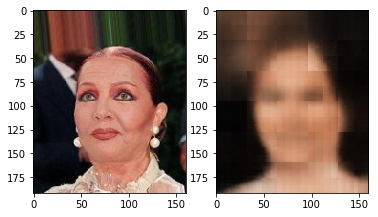

	Epoch 0 batch 3000 gen total loss: 0.9709288229346276 mse loss: 0.2776662603765726 kld loss: 0.0 xe loss: 0.6932625624537468 disc loss: 1.386377789735794 disc acc: 0.5011666816025973


In [0]:
train_discriminator(discriminator, generator, train_loader=train_loader, d_optimizer=d_optimizer, g_optimizer=g_optimizer, num_epochs=1, print_metrics=1000, plot_images=3000, extra_gen_train=16, always_train_disc=False, train_gen=True, train_disc=False, test_loader=test_loader, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

In [0]:
train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, num_epochs=2, extra_gen_train=32, always_train_disc=False, train_gen=True, train_disc=True, test_loader=test_loader, print_metrics=1000, plot_images=2000, display_images=1500, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

In [0]:
train(generator, train_loader, g_optimizer, test_loader=test_loader, print_metrics=500, plot_images=1000, num_epochs=10, display_images=5, scheduler=None, save_path="gen_model_3.pt")

In [0]:
num_epochs = 1
train_gen=True
train_disc=True
always_train_disc=True
extra_gen_train=1
print_metrics=1000
plot_images=4000
display_images=5
d_save_path="disc_model_3.pt"
g_save_path="gen_model_3.pt"


for epoch in range(num_epochs):
  # put both models into train mode
  discriminator.train()
  generator.train()

  # create paths to upload to, so we have at least one backup
  d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
  g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 

  # initialize the batch losses to 0
  mse_loss = 0
  kld_loss = 0
  disc_losses = 0

  d_tr_loss = 0.0
  g_tr_loss = 0.0
  d_test_loss = 0.0
  g_test_loss = 0.0
  test_loss = 0.0
  test_d_loss = 0

  # create lists to save our metrics in
  test_d_acc = []
  batch_losses = []
  batch_accuracies = []

  # loop through the inputs
  for i, (inputs, _) in enumerate(train_loader):
      # if the batch is too small skip it, will cause problems otherwise
      if inputs.shape[0] <= 2:
        continue

      if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()

      d_optimizer.zero_grad()
      g_optimizer.zero_grad()

      # generate our fake images
      if train_gen:
          recon, code, logvar = generator(inputs)
      else:
        with torch.no_grad():
            recon, code, logvar = generator(inputs)

      # concat half of the real images and half of the recons for the discriminator batch
      # it should be different halves
      batch_size = int(inputs.shape[0] // 1.5)
      print("batch_size:", batch_size)
      disc_batch = torch.cat((inputs[:batch_size], recon[-batch_size:]), 0)
      print("disc_batch", disc_batch.shape)
      
      # feed the batch to the discriminator
      d_logits = discriminator(disc_batch)
      print("d_logits", d_logits.shape)
      
      if use_cuda and torch.cuda.is_available():
          ones = torch.ones(batch_size).cuda()
          zeros = torch.zeros(batch_size).cuda()
      else:
          ones = torch.ones(batch_size)
          zeros = torch.zeros(batch_size)

      labels = torch.cat((ones, zeros))
      d_loss = disc_loss2(labels, d_logits)
      
      # calculate the accuracy of our discriminator
      d_preds = torch.sigmoid(d_logits).round()

      d_accuracy = torch.mean((d_preds == labels).double())
      batch_accuracies.append(d_accuracy.item())
      
      # update the discriminator every other step to give the generator time to catch up
      if (train_disc or not_train_gen) and ((always_train_disc or epoch % extra_gen_train == 0) or (not always_train_disc and (np.mean(batch_accuracies) <= 0.80 or np.mean(batch_accuracies[-3:]) <= 0.70))):
        print("Training disc:", np.mean(batch_accuracies))
        d_loss.backward(retain_graph=True)
        d_optimizer.step()
        d_optimizer.zero_grad()
      
      # feed all the reconstructed images into the discriminator for the generator loss
      faked_logits = discriminator(recon)
      
      # update the generator, use no grad if we aren't training the generator to speed things up and save RAM
      if train_gen:
        print("Training gen")
        g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
        g_loss.backward()
        g_optimizer.step()
      else:
        print("Not training gen")
        with torch.no_grad():
          g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)

      g_tr_loss += g_loss.item()
      mse_loss += mse.item()
      kld_loss += kld.item()
      disc_losses += disc_loss.item()

      d_tr_loss += d_loss.item()
      batch_losses.append(g_loss.item())

      if i > 0 and print_metrics != 0 and i % print_metrics == 0:
        print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:", g_loss.item(), "mse loss:", mse.item(), "kld loss:", kld.item(), "xe loss:", disc_loss.item(), "disc loss:", d_loss.item(), "disc acc:", np.mean(batch_accuracies))

      if i % plot_images == 0 and i > 0:
        fig, ax = plt.subplots(1, 2, figsize=(6,6))
        ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
        ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
        plt.show()

  if epoch % display_images == 0:
      # plot a few random images
      try:
        fig, ax = plt.subplots(2, 2, figsize=(6,6))
        fig.suptitle("Training Images")
        ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
        ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
        ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
        ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
        plt.show()
      except Exception as e:
          print(e)

      torch.save(discriminator.state_dict(), d_save_path)
      torch.save(generator.state_dict(), g_save_path)

batch_size: 9
disc_batch torch.Size([18, 3, 192, 160])
d_logits torch.Size([18])
Training disc: 0.9444444514811039
Training gen
batch_size: 9
disc_batch torch.Size([18, 3, 192, 160])
d_logits torch.Size([18])
Training disc: 0.9722222294658422
Training gen
batch_size: 9
disc_batch torch.Size([18, 3, 192, 160])
d_logits torch.Size([18])
Training disc: 0.9629629701375961
Training gen
batch_size: 9
disc_batch torch.Size([18, 3, 192, 160])
d_logits torch.Size([18])
Training disc: 0.9722222294658422
Training gen
batch_size: 9
disc_batch torch.Size([18, 3, 192, 160])
d_logits torch.Size([18])
Training disc: 0.9777777850627899
Training gen
batch_size: 9
disc_batch torch.Size([18, 3, 192, 160])
d_logits torch.Size([18])
Training disc: 0.9814814887940884
Training gen
batch_size: 9
disc_batch torch.Size([18, 3, 192, 160])
d_logits torch.Size([18])
Training disc: 0.9841269914593015
Training gen
batch_size: 9
disc_batch torch.Size([18, 3, 192, 160])
d_logits torch.Size([18])
Training disc: 0.986111

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

In [0]:
for (image, label) in zip(disc_batch, d_preds):
    plt.imshow(image.detach().cpu().permute(1, 2, 0))
    plt.title(str(label))
    plt.show()

Accuracy: tensor(0.6429, device='cuda:0')
0.46198758482933044


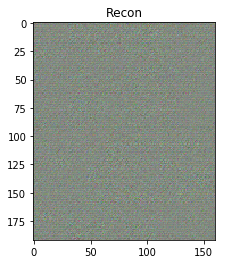

0.5081997513771057


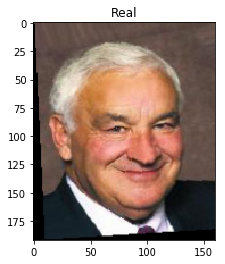

In [0]:
# check that the discriminator is working properly
with torch.no_grad():
    for (inputs, _) in train_loader:
        generator.eval()
        
        recon, mu, logvar = generator(inputs.cuda())
        
        # feed the original images to the discriminator
        real_probs = torch.sigmoid(discriminator(inputs.cuda()))
        fake_probs = torch.sigmoid(discriminator(recon))
        
        probs = torch.cat((real_probs, fake_probs), 0).float()
        labels = torch.cat((torch.ones(inputs.shape[0]), torch.zeros(inputs.shape[0])), 0).cuda()
        
        print("Accuracy:", torch.mean((torch.round(probs) == labels).float()))
        print(fake_probs[0].item())
        plt.imshow(recon[0].cpu().permute(1,2,0))
        plt.title("Recon")
        plt.show()
        
        print(real_probs[0].item())
        plt.imshow(inputs[0].cpu().permute(1,2,0))
        plt.title("Real")
        plt.show()
        
        break

In [0]:
inputs = torch.autograd.Variable(recon.clone().cuda(), requires_grad=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


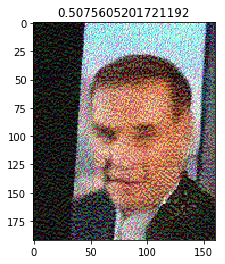

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


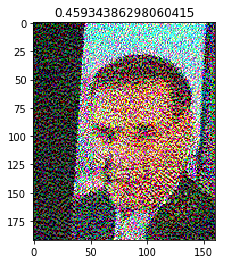

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


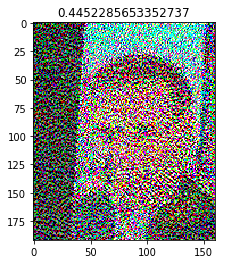

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


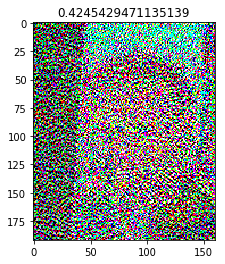

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


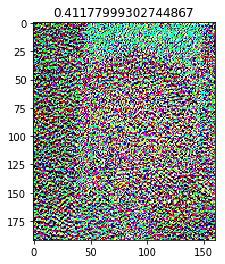

KeyboardInterrupt: ignored

In [0]:
# create a random tensor of the proper size
# inputs = torch.autograd.Variable(torch.randn(2, 3, 192, 160).cuda(), requires_grad=True)

# create an optimizer for our images
r_opt = optim.Adam([inputs], lr=0.001)

# loss function is we want the images to be predicted as real
def rev_loss(d_faked):
    labels = torch.ones(d_faked.shape[0]).cuda()
#     labels = torch.zeros(d_faked.shape[0]).cuda()
    d_loss = nn.functional.binary_cross_entropy_with_logits(d_faked, labels, reduction="mean")
    
    return d_loss

# discriminator.eval()  
  
for j in range(10):  
  losses = []
  for i in range(200):
      logits = discriminator(inputs)
      loss = rev_loss(logits)
#       print(loss.item())
      loss.backward()
      r_opt.step()
      losses.append(loss.item())
      
  plt.imshow(inputs[0].detach().cpu().permute(1, 2, 0) )
  plt.title(str(np.mean(losses)))
  plt.show()

In [0]:
## CHECK MEAN AND VARIANCE OF CODES
with torch.no_grad():
    for (inputs, _) in test_loader:
      generator.encoder.eval()
      generator.decoder.eval()
      # encode the images and reconstruct them
      codes, logvar = generator.encoder(inputs.cuda())
      print("Mean:", torch.mean(codes))
      print("Std:", codes.std())
      recon = generator.decoder(codes)
      d_faked = discriminator(recon)
      print("Faked Logits Mean:", d_faked.mean())
      vae_loss(inputs.cuda(), recon, codes, logvar=logvar, d_faked = d_faked, debug = True)
      break

Mean: tensor(-0.0188, device='cuda:0')
Std: tensor(3.1603, device='cuda:0')
Faked Logits Mean: tensor(0.0726, device='cuda:0')
MSE Loss Raw: tensor(0.0024, device='cuda:0')
MSE Loss Weighted: tensor(0.4753, device='cuda:0')
KLD Loss Raw: tensor([0.])
KLD Loss Weighted: tensor([0.])
Disc Loss Raw: tensor(0.7382, device='cuda:0')
Disc Loss Weighted: tensor(0.1476, device='cuda:0')
Total Loss (weighted): tensor(0.6230, device='cuda:0')


#### Additional Training on Personal Images

In [0]:
!mkdir data/Train
!cp -r data/images/Training_Pictures data/Train/Images

In [0]:
train_dataset2 = torchvision.datasets.ImageFolder(
        root="data/Train",
        transform=transform
    )

train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

In [0]:
train_discriminator(discriminator, generator, train_loader2, d_optimizer, g_optimizer, test_loader=train_loader2, num_epochs=5, print_metrics=1000, extra_gen_train=2, plot_images=2000, train_gen=True, train_disc=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

RuntimeError: ignored

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()

#### Additional Training on Specific Images

In [0]:
# # download and unzip the data
# url = "https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_64x64.zip"
# if not os.path.exists("gwb_images.zip"):
#   wget.download(url, 'gwb_images.zip')

#   zip_ref = zipfile.ZipFile('gwb_images.zip', 'r')
#   zip_ref.extractall('data/gwb')
#   zip_ref.close()

In [0]:
# use the existing encoder to create a GWBush decoder
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = model.encoder
gwb_decoder = Decoder(2048)
gwb_model = SingleModel(encoder, gwb_decoder)
gwb_params = gwb_model.decoder.parameters()

# run on GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    gwb_decoder.cuda()
    gwb_model.cuda()
    
optimizer = optim.Adam(gwb_params, lr=0.002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)    

In [0]:
# gwb dataset
BATCH_SIZE = 64
data_path = "data/gwb"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomChoice([
        torchvision.transforms.RandomAffine(degrees=7, translate=(0.05,0.05), scale=(0.9,1.1), shear=3, resample=False, fillcolor=0),
        torchvision.transforms.RandomResizedCrop((192,160), scale=(0.90, 1.1)),
      ]),
    torchvision.transforms.ToTensor(),
    ])

gwb_train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

gwb_train_loader2 = torch.utils.data.DataLoader(
    gwb_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [0]:
for (images, _) in gwb_train_loader2:
  plt.imshow(images[0].permute(1,2,0))
  break

In [0]:
train(gwb_model, gwb_train_loader2, optimizer, print_metrics=0, num_epochs=200, display_images=20, scheduler=scheduler, save_path="./gwb_model.pt")